# Coastal Endurance Oregon Inshore Surface Mooring - Seafloor Multi-Function Node (MFN) - Velocity Profiler (600kHz) Data Quality Report

**Evaluation Date**: 7/18/2018

**Evaluator**: Alexandros Tasianas

## Review Summary

This report describes computations used to investigate the quality of the data obtained from the Acoustic Doppler current profiler (ADCP) instrument which is deployed at the  Coastal Endurance array on the Surface Mooring - Seafloor Multi-Function Node (MFN).  This report summarizes the data quality review of this dataset (CE01ISSM). 

The report tries to provide an understanding of the data for different time periods. We focus on data from 4/17/2014 (Deployment 1) to 03/04/2018 (Deployment 9) for this particular location in Oregon and plan to use the same approach of going through a data quality methododlgy for ADCP data from the Coastal Pioneer Central inshore profiler carried out by Kianoosh Yousefi and compare the two. 

In general, my review will focus on several of the steps introduced during the workshop, some of which may be repeated for different instruments or time periods of interest.


## 1. Selected instruments included in this report
In this report, we will evaluate the ADCP from the Coastal Endurance Oregon Inshore Surface Mooring - Seafloor Multi-Function Node (MFN) - Velocity Profiler (600kHz)  (CE01ISSM), focusing on the time period from the spring of 2014 (Deployment 1) to the spring of 2018 (Deployment 9). Additional instruments on the ADCP are listed for reference and could be used for further evaluation.

Instrument | Reference Designator | Method | Stream 
 -- | -- | -- | --
pCO2 Water | [CE01ISSM-MFD35-05-PCO2WB000](http://ooi.visualocean.net/instruments/view/CP02PMUO-WFP01-03-CTDPFK000) | telemetered | pco2w_abc_dcl_power
Seawater pH | CE01ISSM-MFD35-06-PHSEND000 | telemetered | phsen_abcdef_dcl_instrument
Seafloor pressure | CE01ISSM-MFD35-02-PRESFA000 | recovered-inst | presf_abc_tide_measurement
Seafloor pressure | CE01ISSM-MFD35-02-PRESFA000 | recovered-inst | presf_abc_wave_burst_recovered

We would like to focus however on recovered-inst data stream in this review. A graph of data availability is available in the link below https://ooinet.oceanobservatories.org/data_access/#CE01ISSM-MFD35-04-ADCPTM000/adcp_velocity_earth

Once the link is opened we open the data for the recovered-inst data as the delivery method. 

In [0]:
# Setup Instrument Variables
site = 'CE01ISSM'
node = 'MFD35'
instrument = '04-ADCPTM000'
method = 'recovered_inst'
stream = 'adcp_velocity_earth'

## 2. Time periods of interest
We will focus on the following time periods for the data evaluation:

• Total period: April 17, 2014 to April 3, 2018 - All of the Deployments (1-9)

• Total Period for deployment 7

• A week-long period during deployment 7

• Total period during deployment 3


## 3. Related Metadata
In this section, we will review some of the metadata available in the system to make sure it is present and correct.

Before we get started, we need to set up our Python environment with some libraries, variables and functions we will need later in this report, such as to specify some functions to convert timestamps, as seen below.

In [0]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd


The API login information including API Username and Token can be obtained from the OOI Net account.

In [0]:
# API Information
USERNAME =''
TOKEN= ''

DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'


In [0]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None


### 3a. Vocabulary Metadata
First, we'll obtain the basic vocabulary information (metadata) from the system to make sure we have the right instrument. We will then request the data as shown by the script below.

In [0]:
# Setup the API request url
data_request_url ='/'.join((VOCAB_API,site,node,instrument))
print(data_request_url)

# Grab the information from the server
r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
data = r.json()
data

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/CE01ISSM/MFD35/04-ADCPTM000


[{'@class': '.VocabRecord',
  'model': 'WorkHorse Sentinel 600khz',
  'manufacturer': 'Teledyne RDI',
  'vocabId': 8,
  'refdes': 'CE01ISSM-MFD35-04-ADCPTM000',
  'instrument': 'Velocity Profiler (600kHz)',
  'tocL1': 'Coastal Endurance',
  'tocL2': 'Oregon Inshore Surface Mooring',
  'tocL3': 'Seafloor Multi-Function Node (MFN)',
  'mindepth': 25.0,
  'maxdepth': 25.0}]

### 3b. Deployment Information
Next, we will get some information about the deployments for this instrument.  We will grab all of the deployments available in the system from 2014-2018 and then output the date ranges, latitude/longitude, asset ID, and sensor ID.  Note that the **reference designator** specified above represents the geographical location of an instrument across all deployments (e.g. the ADCP on the Coastal Endurance Oregon Inshore Velocity Profiler), the **Sensor ID** (and its Asset ID equivalent) represent the specific instrument used for a given deployment (i.e. a unique make, model, and serial numbered instrument).

In [0]:
# Setup the API request url
data_request_url = ASSET_API + '/events/deployment/query'
params = {
  'beginDT':'2014-04-17T00:00:00.000Z',
  'endDT':'2018-03-04T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+instrument,   
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,396.0,1.0,44.65828,-124.09560,CGINS-ADCPTM-18225,2014-04-17 20:45:00,2014-08-16 22:30:00
1,2920.0,2.0,44.65833,-124.09583,CGINS-ADCPTM-21517,2014-10-10 17:45:00,2015-04-12 00:30:00
2,2460.0,3.0,44.65833,-124.09527,CGINS-ADCPTM-21522,2015-06-03 17:15:00,2015-10-07 00:00:00
3,2156.0,4.0,44.66010,-124.09582,CGINS-ADCPTM-19023,2015-10-08 12:02:00,2016-05-10 15:22:00
4,396.0,5.0,44.65828,-124.09525,CGINS-ADCPTM-18225,2016-05-18 15:44:00,2016-10-02 20:15:00
5,2920.0,6.0,44.65975,-124.09504,CGINS-ADCPTM-21517,2016-09-30 16:45:00,2017-04-17 19:45:00
6,2460.0,7.0,44.65628,-124.09522,CGINS-ADCPTM-21522,2017-04-19 04:18:00,2017-10-12 21:50:57
7,2156.0,8.0,44.65970,-124.09486,CGINS-ADCPTM-19023,2017-10-12 17:50:38,2018-04-01 10:22:00


The table above illustrates that we have results for 8 deployments, with their location in terms of latitude and longiture, the sensor used and the start and end date of each deployment. The frist deployment started on the 17 april 2014 and ended on the 16 august of the same year. In the sme way the start and end dates of all the other deployments are stated.

### 3c. Calibration Information
When the system delivers data, it often uses a number of calibration coefficients to generate derived data products.

It turns out that this ADCP instrument has a lot of calibration information, as can be seen from the complete list below which includes data on location, latitude, longitude etc.


In [0]:
# Setup the API request url
data_request_url = ASSET_API + '/asset/cal'
params = {
  'beginDT':'2014-04-17T00:00:00.000Z',
  'endDT':'2018-03-04T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+'04-ADCPTM000',
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()
data

[{'@class': '.XDeployment',
  'location': {'depth': 25.0,
   'location': [-124.0956, 44.65828],
   'latitude': 44.65828,
   'longitude': -124.0956,
   'orbitRadius': None},
  'node': None,
  'referenceDesignator': 'CE01ISSM-MFD35-04-ADCPTM000',
  'sensor': {'@class': '.XInstrument',
   'calibration': [{'@class': '.XCalibration',
     'name': 'CC_depth',
     'calData': [{'@class': '.XCalibrationData',
       'value': 25000.0,
       'comments': None,
       'eventId': 37874,
       'assetUid': 'CGINS-ADCPTM-18225',
       'eventType': 'CALIBRATION_DATA',
       'eventName': 'CC_depth',
       'eventStartTime': 1397692800000,
       'eventStopTime': None,
       'notes': None,
       'tense': 'UNKNOWN',
       'dataSource': 'CGINS-ADCPTM-18225__20140417_Cal_Info.xlsx',
       'lastModifiedTimestamp': 1531140655840},
      {'@class': '.XCalibrationData',
       'value': 25000.0,
       'comments': '[mm]; NOT NEEDED FOR ENDURANCE',
       'eventId': 11161,
       'assetUid': 'CGINS-ADCPTM

From the calibration table above, we can see that we have 90 different entries and that calibration 1 began on 4/17/2014.  The system uses the calibration values that are closest in time but before the deployment start date. Note also, that calibrations do not have an end date.  It is assumed they are valid until the next calibration for the specific asset. 

So in this case, for the last i.e Deployment 9, the last calibration took place on 30/08/2016 so no calibrations were performed in 2015 and 2017. 


### 3d. Annotations
Finally, we will pull any relevant annotations for the instrument we are using.

In [0]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT':int(datetime.date(2014,4,17).strftime('%s'))*1000,
  'endDT':int(datetime.date(2018,3,4).strftime('%s'))*1000,
  'refdes':site+'-'+node+'-'+instrument,
}

r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,"The file system on the SD card used by embedded Linux card comprising DCL35 became corrupted on Saturday, October 29, 2016. I have captured and attached a log of the boot messages below.\n\nhttps://www.embeddedarm.com/blog/preventing-filesystem-corruption-in-embedded-linux/\n\nAffected instruments are:\nADCPT\nPCO2W\nPHSEN\nPRESF\nVEL3D\nAll instruments are set to log internally. Will not receive telemetered data, but do not anticipate complete loss of data.",851.0,MFD35,None,CE01ISSM,2016-10-29,2017-05-15
1,"Lost communication with DCL35, on the MFN of CE01ISSM sometime after 2017/05/12 04:32:31.744. Reason unknown. \n\nAttempted to log into the system and establish both an ssh connection and a minicom session with no success. Minicom session showed zero activity, suggesting the system is completely offline. With the exception of the VEL3D, all instruments hosted by DCL35 are autonomous.\n\nNo further data should be expected from:\nADCPT (recording internally)\nPRESF (recording internally)\nPC02W (recording internally)\nPHSEN (recording internally)\nVEL3D (status unknown)",852.0,MFD35,None,CE01ISSM,2017-05-12,2017-10-31
2,"All of the inshore surface moorings suffer from an issue called the 'top of the day problem.' \r\r\n\r\r\nA race condition exists in the CPM firmware when transferring daily log files harvested from the various sub-components in a buoy system (e.g. DCL16, CPM3, DCL35, etc) over the Iridium RUDICS connection. The primary CPM rsync's data files from the various sub-components to a central data directory. The first time a daily file is created/copied into that directory (usually shortly after midnight), a compressed copy of the file is created and that compressed file is queued up in a separate text file for transmission to shore. The transfer routine reads that text file and processes the files from that list in order from top to bottom.\r\r\n\r\r\nOnce that compressed file is transferred to shore, no further updates for that file are sent to shore. Meanwhile, the CPM continues to rsync data from the different sub-components, updating the original daily log file.\r\r\n\r\r\nThe net result is that data is accumulating in the daily log file for an instrument, but we may see only one record (or none) depending on when the rsync job occurred and the compressed file was created and staged for transfer to shore.\r\r\n\r\r\nThis affects telemetered data only.",868.0,None,None,CE01ISSM,2014-04-17,2016-10-01
3,"Correcting the iridium data telemetry issues, permitting full telemetry of data files, resulting in greater power consumption than anticipated. Result is power level of the battery pack has dropped below operational limits and subsystems can no longer power instruments. Shutting the mooring down, and placing in a low power maintenance mode.",869.0,None,None,CE01ISSM,2016-08-08,2016-10-04
4,"On Monday, Mon Dec 12 15:30:00 2016, stopped receiving any data from CTDBP3. No indication as to possible cause.\r\r\n\r\r\n",870.0,None,None,CE01ISSM,2016-12-12,2017-05-31
5,"The file system on the SD card used by embedded Linux card comprising DCL35 became corrupted on Saturday, October 29, 2016. I have captured and attached a log of the boot messages below.\n\nhttps://www.embeddedarm.com/blog/preventing-filesystem-corruption-in-embedded-linux/\n\nAffected instruments are:\nADCPT\nPCO2W\nPHSEN\nPRESF\nVEL3D\nAll instruments are set to log internally. Will not receive telemetered data, but do not anticipate complete loss of data.",860.0,MFD35,None,CE01ISSM,2016-10-29,2017-05-15
6,"Lost communication with DCL35, on the MFN of CE01ISSM sometime after 2017/05/12 04:32:31.744. Reason unknown. \n\nAttempted to log into the system and establish both an ssh connection and a minicom session with no success. Minicom session showed zero activity, suggesting the system is completely offline. With the exception of the VEL3D, all instruments hosted by DCL35 are autonomous.\n\nNo further data

There are no annotations in the system specific to this instrument as in the "sensor" column we have the word "none". Any annotations present belong to a higher hierarchical level.

## 4. The full dataset
Now we will take a look at a large range of data.  We shall look at all of the Deployments (1-9).  First we need to add some additional libraries to our Python environment for that.

In [0]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean

/opt/conda/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


For simplicity, we used the Data Portal to make a download request for all available data.  After receiving the e-mail, we looked through the results and here we specify just the netCDF file that includes the ADCP data for all of the deployments (1-9).  Using this data file, we will create a few different plots to better understand the available data. We notice also that there is no data available for deployment 9 since it is still under deployment and also regarding deployment 8 we do have the raw data but we cannot injust it. This means that due to the immense amount of data available and in order to concentrate on more specific data we will concentrate on data from deployment 7 to start with and then also move on to data from deployment 3.

Here are the results from deployment 7.

In [0]:
data_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/alexandros.tasianas@uit.no/20180718T141728-CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0007_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth_20170419T043000-20171012T213000.nc'

# Open the dataset
ds = xr.open_dataset(data_url)

# Swap the dimensions
ds = ds.swap_dims({'obs': 'time'})
ds

<xarray.Dataset>
Dimensions:                         (bin: 30, time: 8483)
Coordinates:
    obs                             (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 ...
  * time                            (time) datetime64[ns] 2017-04-19T04:30:00 ...
    pressure                        (time) float64 ...
    lat                             (time) float64 ...
    lon                             (time) float64 ...
Dimensions without coordinates: bin
Data variables:
    deployment                      (time) int32 ...
    id                              (time) |S64 ...
    bin_1_distance                  (time) float32 ...
    cell_length                     (time) float32 ...
    correlation_magnitude_beam1     (time, bin) float32 ...
    correlation_magnitude_beam2     (time, bin) float32 ...
    correlation_magnitude_beam3     (time, bin) float32 ...
    correlation_magnitude_beam4     (time, bin) float32 ...
    driver_timestamp                (time) datetime64[ns] ...
    echo_intensit

We will now create a quick timeseries plot of temperature.  If we plot the entire dataset related to the time period of Deployment 7, we observe lower temperatures during the summer months (especially during July) probably indicating some cold water currents affecting the dataset. At the beginning of the summer we also have some high fluctuations in temperature which is understandable as we go through a rather unstable period of the year in terms of temperature and weather. So the data here looks quite correct. 

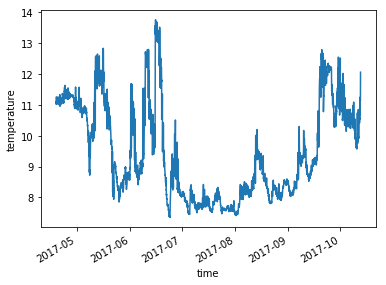

In [0]:
((ds['temperature'])/100).plot();

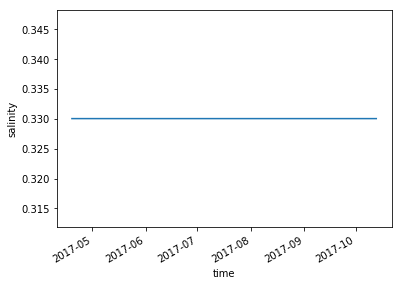

In [0]:
((ds['salinity'])/100).plot();

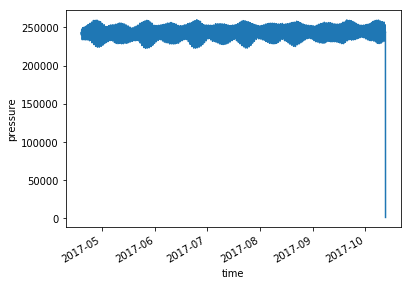

In [0]:
((ds['pressure'])*10).plot();

For salinity it looks like we have a constant value of 0.33 throughout the period studied. This could either indicate a problem with the data or that the deployment team are considering a standard salinity. For pressure we have an oscillating behouviour around 240000 Pa for the entire period, corresponding to the movement of the ADCP in the water column affected by the wave motion and currents movement. The edge of the predsure graph seems to have an outlyer of nearly 0 pressure which is far away from the rest of the data.

If we now, take a look at the water velocity in the east/west direction. The data is not clearly visible and only visible for the 20-30 bin size. Actually when checking the availability of the data we see that the data for this interval period is not available and thus explaining the blurred appearance of the dataset.

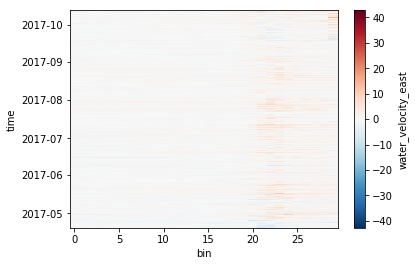

In [0]:
((ds['water_velocity_east'])/100).plot();


In [0]:
print(len(ds['water_velocity_east']))

8483


Next, we will create some histograms to see the full range of data. Thanks to xarray, this is easy to do in just one line.  Histograms aren't really ideal for understanding a  dataset since all depths are included, but let's see what they look like anyway. So again for salinity we get a single bar histogram at 33 and for temperature the most common temperature is around 8 degrees and there is also another peak at around 11 degrees C.There is a binomial distribution around the data and the temperatures recorded are all within a reasonable range.

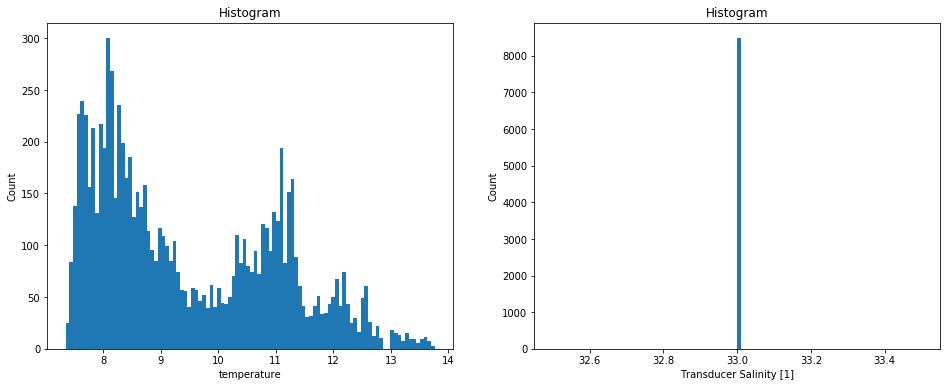

In [0]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
((ds['temperature'])/100).plot.hist(bins=100, ax=ax1)
ds['salinity'].plot.hist(bins=100, ax=ax2);


The good news is, the data doesn't appear to include any significant outliers.  As to whether the times of warm temperature or relatively fresher waters are valid, we'd have to look at the dataset more closely, e.g. specific depths or time periods.

So, we will now create a profile timeseries to better understand the full dataset.

In [0]:
dtime = ds['time'].values
pressure = ((ds['pressure'])*10).values
temperature = ((ds['temperature'])/100).values
salinity = ds['salinity'].values


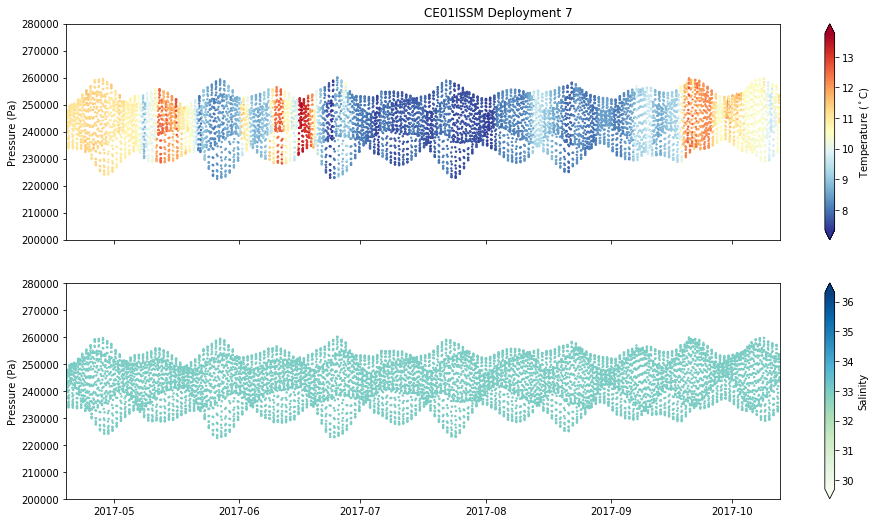

In [0]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

ax1.set_ylim(200000, 280000)

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (Pa)')
ax2.set_ylabel('Pressure (Pa)')

fig.suptitle('CE01ISSM Deployment 7')
fig.subplots_adjust(top=0.95);


We are using ADCP so we expect the instrument to remain stable in the seawater and not change its depth. We actually observe an oscillation due to the wave motion that is being exerted on the ADCP. For each day of the studied period we observe the pressure oscillating between a minimum at aprox 220000 Pa and a maximum at 260000 Pa which is then colored by temperature in the 1st graph and by salinity in the 2nd graph. Salinity is constant at 33 Psu that is why we observe points of the exact same colour where as temperature varies with time from 8-14 degrees C.

We will now plot the data for the seawater velocity in all 3 directions for the time period of deployment 6 (04 to 10/ 2017)

In [0]:
time = ds['time'].data
bin_depths = ds['bin_depths'].data.T
east = ds['eastward_seawater_velocity'].data.T
north = ds['northward_seawater_velocity'].data.T
up = ds['upward_seawater_velocity'].data.T

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
lim_east = float("%2.2f" % np.nanpercentile(east, 90))
lim_north = float("%2.2f" % np.nanpercentile(north, 90))
lim_up = float("%2.2f" % np.nanpercentile(up, 90))
u_v_w = max([lim_east, lim_north, lim_up])

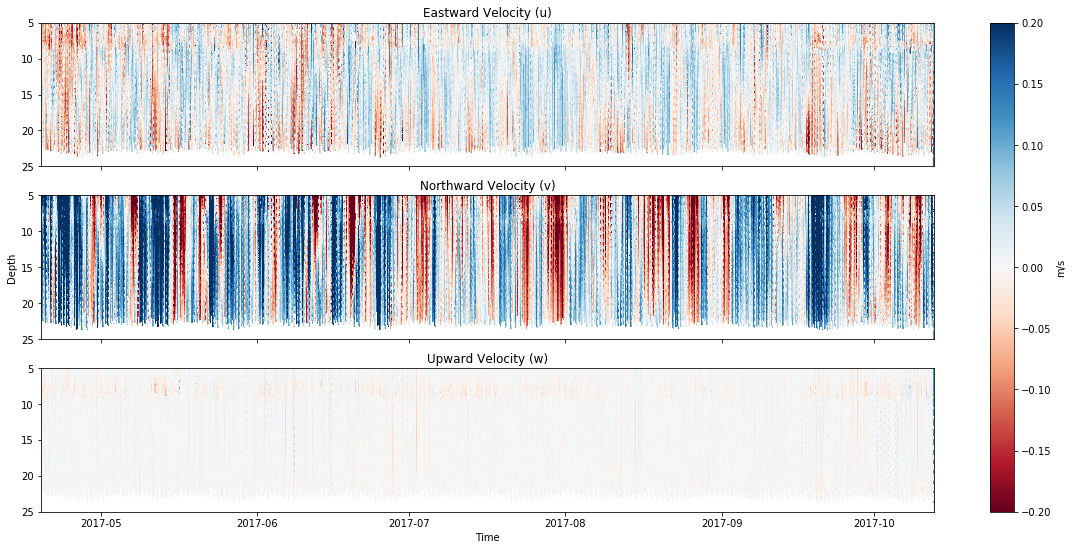

In [0]:
plt.close()
fig, axes = plt.subplots(3, sharex=True)
fig.set_size_inches(20, 9)

p0 = axes[0].pcolormesh(time, bin_depths, east, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
axes[0].set_ylim(5,25)
axes[0].set_title('Eastward Velocity (u)')
axes[0].invert_yaxis()

p1 = axes[1].pcolormesh(time, bin_depths, north, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
axes[1].set_title('Northward Velocity (v)')
axes[1].set_ylim(5,25)
axes[1].invert_yaxis()
axes[1].set_ylabel('Depth')

p2 = axes[2].pcolormesh(time, bin_depths, up, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
axes[2].set_title('Upward Velocity (w)')
axes[2].set_ylim(5,25)
axes[2].invert_yaxis()
axes[2].set_xlabel('Time')

fig.colorbar(p0,ax=axes.ravel().tolist(), label='m/s')

plt.show()

The velocity oscillates more from day to day in the N/S direction than in the E/W direction. Upward velocity is more stable as an ADCP does not move much in this direction.

If we compare the above figure to the one obtained in the data validation report by Kianoosh Yousefi carried out on a different ADCP dataset but for the same period in 2017, we observe similar trends for these velocities. The eastward velocity in both datasets is dominated more by red colours so a westerly direction of the water dominates whereas the northward velocity is dominated by blue colours, thus indicating more northerly oriented velocities.

We will now look at other variables such as pitch, for the same time period. 

In [0]:
time = ds['time'].data
bin_depths = ds['bin_depths'].data
BinDist = ds['bin_1_distance'].data
Heading = ds['heading'].data
Pitch = ds['pitch'].data
Celllength = ds['cell_length'].data
roll = ds['roll'].data

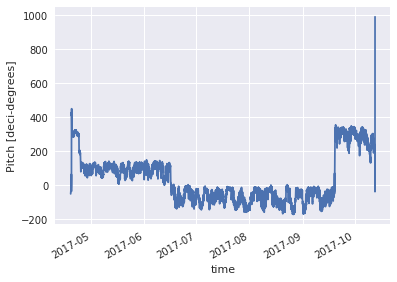

In [0]:
ds['pitch'].plot()

Pitch is presented in deci-degrees which is a discrepancy in the data so we need to divide the y axis by 100 as shown below in order to convert the data into acceptable units. There is thus an error in the metadata. The units of the pitch, roll, and heading should be in centi-degree instead of deci-degree. 

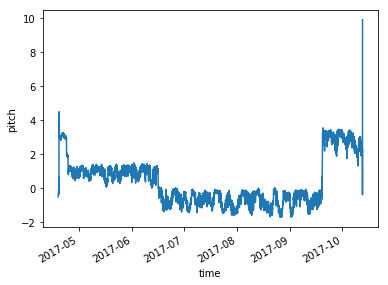

In [0]:
((ds['pitch'])/100).plot()

We observe in general an oscillation of pitch values and 2 abrupt changes in the mean pitch i.e. in the mid of june and the mid of september 2017. There is increased pitch towards the last month of the studied period and this may be due to an increase in water velocities which in turn are caused by increased vertical tension on the tether of the boat in faster flows. So the 2 above-mentionned abrupt changes in pitch can be explained by a change in the speed of the boat. It is thus important and necessary to accurately know the ship's velocity (differential GPS, bottom tracking)and pitch.

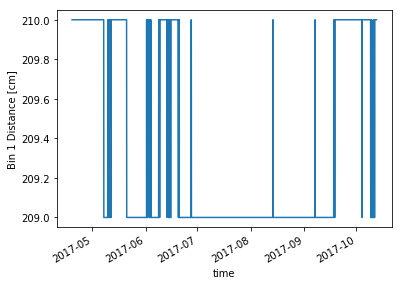

In [0]:
ds['bin_1_distance'].plot()

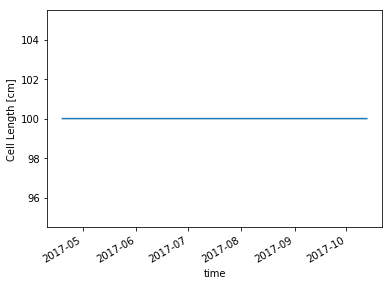

In [0]:
ds['cell_length'].plot()

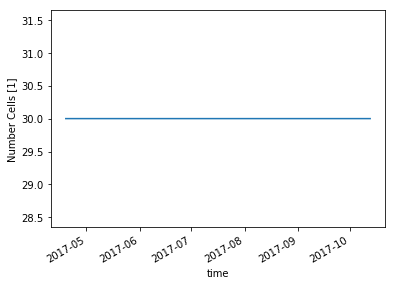

In [0]:
ds['num_cells'].plot()

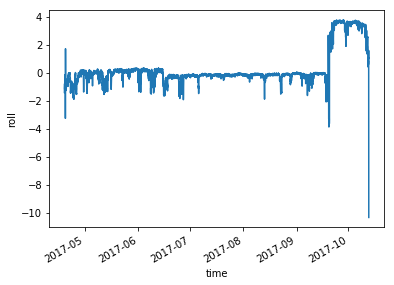

In [0]:
((ds['roll'])/100).plot()

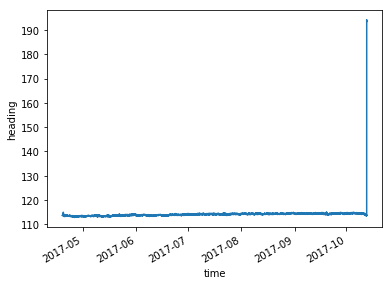

In [0]:
((ds['heading'])/100).plot()

The "heading" is related to the measurement of the rotation parameter which is measured by a flux-gate and a gyrocompass.  A potential heading error like the one observed at the end of the period of study in October 2017 produces a velocity component perpendicular to the ship steaming. It also does not allow us to see more in detail the data for the vast majority of the study period as this outlyer is far away from the average heading.

If we now take a look at the mean of pitch, roll and heading we can see the following:

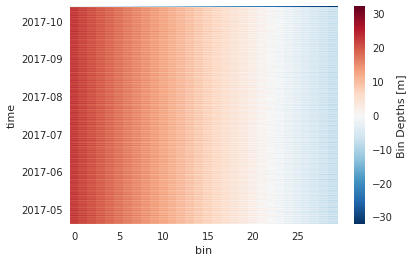

In [0]:
ds['bin_depths'].plot()

The data seems fine. The instrument compensates for apparent changes in bin depth due to instrument tilt and roll.

For comparison reasons we will now folow the same procedure as above but for deploymnet 3 this time in order to compare the results with deployment 7 results.

In [0]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean

In [0]:
data_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/alexandros.tasianas@uit.no/20180718T141728-CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0003_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth_20150603T173000-20151006T233000.nc'

# Open the dataset
ds = xr.open_dataset(data_url)

# Swap the dimensions
ds = ds.swap_dims({'obs': 'time'})
ds

<xarray.Dataset>
Dimensions:                         (bin: 59, time: 6013)
Coordinates:
    obs                             (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 ...
  * time                            (time) datetime64[ns] 2015-06-03T17:30:00 ...
    pressure                        (time) float64 ...
    lat                             (time) float64 ...
    lon                             (time) float64 ...
Dimensions without coordinates: bin
Data variables:
    deployment                      (time) int32 ...
    id                              (time) |S64 ...
    bin_1_distance                  (time) float32 ...
    cell_length                     (time) float32 ...
    correlation_magnitude_beam1     (time, bin) float32 ...
    correlation_magnitude_beam2     (time, bin) float32 ...
    correlation_magnitude_beam3     (time, bin) float32 ...
    correlation_magnitude_beam4     (time, bin) float32 ...
    driver_timestamp                (time) datetime64[ns] ...
    echo_intensit

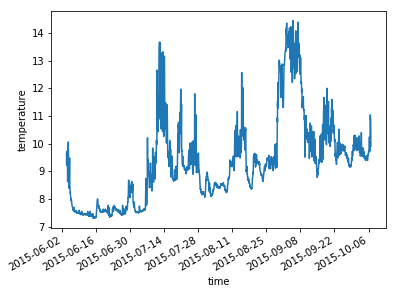

In [0]:
((ds['temperature'])/100).plot();

For both Depl. 3 and 7 we observe a similar trend in temperature increase from the month of July onwards. The increase in T is not constant but occurs with an oscillatory mode reaching peaks 2 or 3 times during the deployment period. This is normal as we are in the summer and expect the temperature to increase on average during that period.

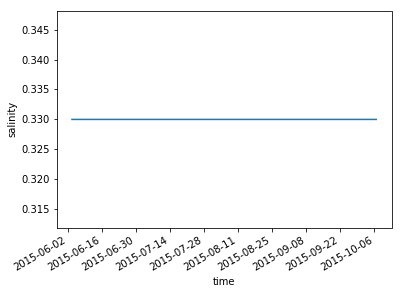

In [0]:
((ds['salinity'])/100).plot();

Salinity again looks fine and is constant at 0.33 as in the other deployment.

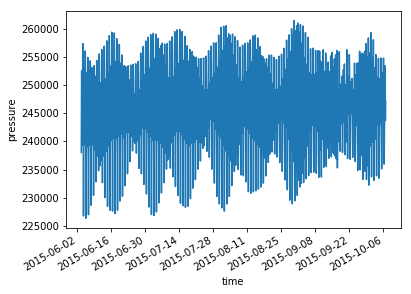

In [0]:
((ds['pressure'])*10).plot();

Again the pressure profile looks good illustrating an oscillatory pattern around 250 000 Pa.

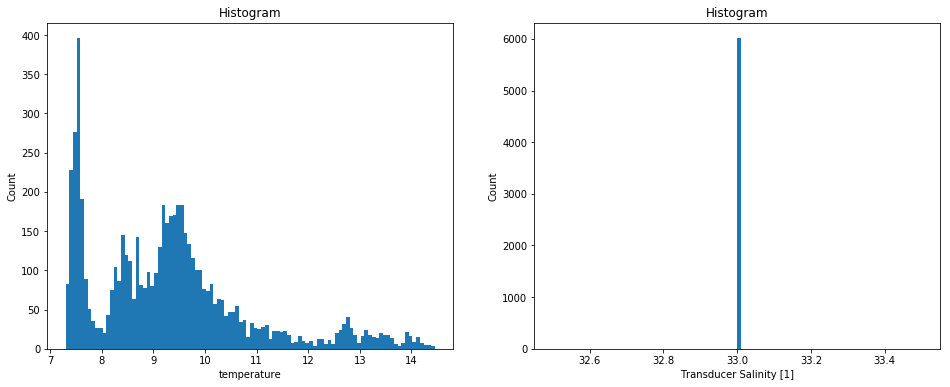

In [0]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
((ds['temperature'])/100).plot.hist(bins=100, ax=ax1)
ds['salinity'].plot.hist(bins=100, ax=ax2);

The temperature histogram seems similar to the one from Depl. 7 but it is shifted a few degrees to the left, meaning that the temperature peaks here are at 7 and 9.5 degress (rather than at  and 11 degrees for depl. 7).

In [0]:
dtime = ds['time'].values
pressure = ((ds['pressure'])*10).values
temperature = ((ds['temperature'])/100).values
salinity = ds['salinity'].values


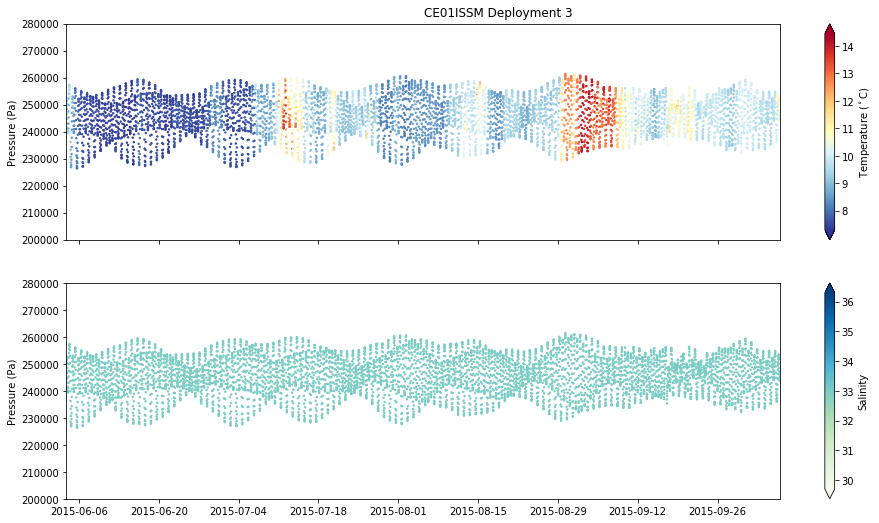

In [0]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

ax1.set_ylim(200000, 280000)

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (Pa)')
ax2.set_ylabel('Pressure (Pa)')

fig.suptitle('CE01ISSM Deployment 3')
fig.subplots_adjust(top=0.95);

For each day of the studied period we again observe the pressure oscillating between a minimum at aprox 220000 Pa and a maximum at 260000 Pa which is then colored by Temperature in the 1st graph and by salinity in the 2nd graph. Salinity is constant at 33 Psu that is why we observe points of the exact same colour whereas temperature varies with time from 9-13 degrees C. The temperatures for depl. 3 are in general lower than for depl. 7 as we observe more temperatures below the average of 11 degrees. The only period with temperatures above average is mainly at the end of august, which seems an acceptable result as we are at the end of the summer.

In [0]:
time = ds['time'].data
bin_depths = ds['bin_depths'].data
BinDist = ds['bin_1_distance'].data
Heading = ds['heading'].data
Pitch = ds['pitch'].data

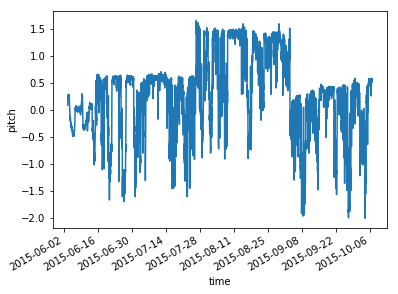

In [0]:
((ds['pitch'])/100).plot()

The initial pitch values are again divided by 100 in order to convert the deci-degrees into acceptable values and correct this discrepancy in the data. We again observe in general an oscillation of pitch values and at least 2 abrupt changes in the mean pitch so the patterns observed in the data seem to be coherent to what we have seen for depl. 7.

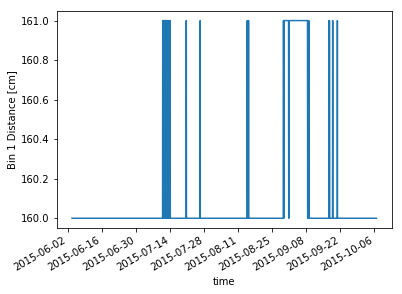

In [0]:
ds['bin_1_distance'].plot()


The bin distance in depl. 7 varies from 209-210 cm (1cm difference) and in depl. 3 from 160-161 cm (also 1 cm difference). So there seems to be a coherence in the degree of variation of bin size between the 2 deployments.

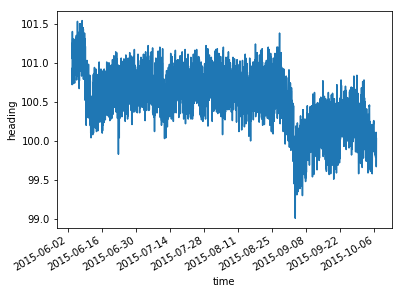

In [0]:
((ds['heading'])/100).plot()

The y axis units related to the heading data are corected by dividing them by 100. Here we do not have any possible heading errors, like in depl. 7, so we can clearly see the heading oscillating around 100.5 and the 2 moments in time where we have a change in the average heading i.e. at 06/08/2018 and at 08/30/2018. So this data for depl. 3 is of a higher quality that for depl. 7 as far as the heading is concerned.

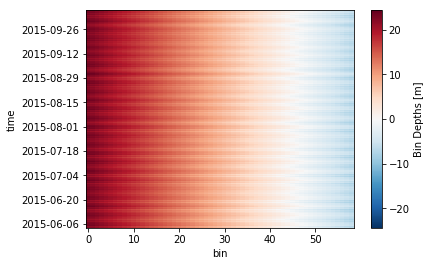

In [0]:
ds['bin_depths'].plot()

The bin depths again seem fine and present similar results to those of deployment 7.

We will now plot the data for the seawater velocity in all 3 directions for the period of deployment.

In [0]:
time = ds['time'].data
bin_depths = ds['bin_depths'].data.T
east = ds['eastward_seawater_velocity'].data.T
north = ds['northward_seawater_velocity'].data.T
up = ds['upward_seawater_velocity'].data.T

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
lim_east = float("%2.2f" % np.nanpercentile(east, 90))
lim_north = float("%2.2f" % np.nanpercentile(north, 90))
lim_up = float("%2.2f" % np.nanpercentile(up, 90))
u_v_w = max([lim_east, lim_north, lim_up])

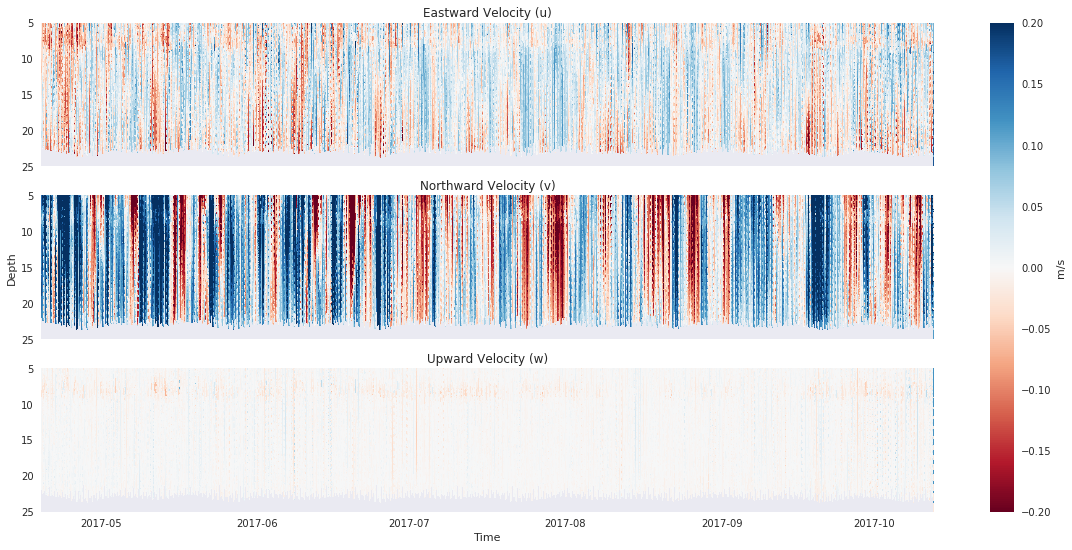

In [0]:
plt.close()
fig, axes = plt.subplots(3, sharex=True)
fig.set_size_inches(20, 9)

p0 = axes[0].pcolormesh(time, bin_depths, east, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
axes[0].set_ylim(5,25)
axes[0].set_title('Eastward Velocity (u)')
axes[0].invert_yaxis()

p1 = axes[1].pcolormesh(time, bin_depths, north, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
axes[1].set_title('Northward Velocity (v)')
axes[1].set_ylim(5,25)
axes[1].invert_yaxis()
axes[1].set_ylabel('Depth')

p2 = axes[2].pcolormesh(time, bin_depths, up, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
axes[2].set_title('Upward Velocity (w)')
axes[2].set_ylim(5,25)
axes[2].invert_yaxis()
axes[2].set_xlabel('Time')

fig.colorbar(p0,ax=axes.ravel().tolist(), label='m/s')

plt.show()

Once more the velocity from depl. 3 also oscillates more i.e. there is a higher velocity change from day to day in the N/S direction than in the E/W direction. Upward velocity is more stable as an ADCP does not move much in this direction. 

We will now extract the bin depths, east, north, and west velocity values along the time dimensions for this deployment.

In [0]:
ds1 = ds.sel(time=slice('2017-05-01 00:00:00', '2017-10-01 00:00:00'))

time_ds1 = ds1['time'].data
depth_ds1 = ds1['bin_depths'].data.T
U_ds1 = ds1['eastward_seawater_velocity'].data.T
V_ds1 = ds1['northward_seawater_velocity'].data.T
W_ds1 = ds1['upward_seawater_velocity'].data.T
temp_ds1 = ds1['temperature'].data/(100)
pres_ds1 = ds1['pressure'].data

ULim_ds1 = float("%2.2f" % np.nanpercentile(U_ds1, 90))
VLim_ds1 = float("%2.2f" % np.nanpercentile(V_ds1, 90))
WLim_ds1 = float("%2.2f" % np.nanpercentile(W_ds1, 90))
CMax_ds1 = max([ULim_ds1, VLim_ds1, WLim_ds1])
CMax_ds1

0.19

Text(0.5,0,'Time')

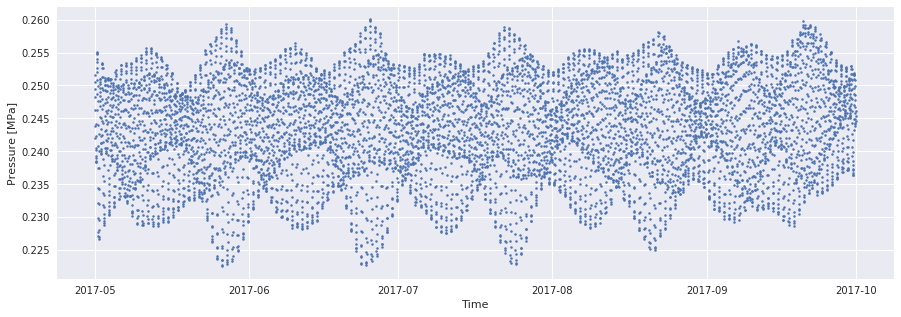

In [0]:
ax = plt.subplots(figsize = (15,5))
plt.plot(time_ds1, pres_ds1/1e5, linestyle = 'None', marker = '.', markersize = 5)
ax[1].set_ylabel('Pressure [MPa]')
ax[1].set_xlabel('Time')

Text(0.5,0,'Time')

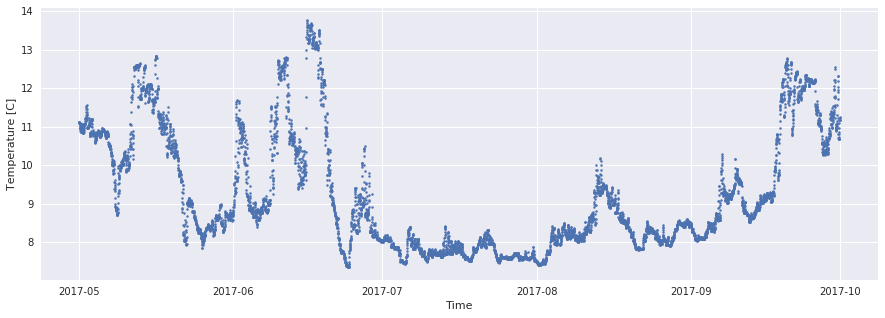

In [0]:
ax = plt.subplots(figsize = (15,5))
plt.plot(time_ds1, temp_ds1, linestyle = 'None', marker = '.', markersize = 5)
ax[1].set_ylabel('Temperature [C]')
ax[1].set_xlabel('Time')

## 5. A closer look
Now let's look at one week around the switchover between Deployments 6 and 7, which corresponds to the dates between the 13-17 april 2017. For this step, we will grab the data directly from the API using a synchronous request, which is limited to less datapoints.


In [0]:
# Setup request for instrument data
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-04-13T00:00:00.000Z',
  'endDT':'2017-04-20T00:00:00.000Z',
  'limit':10000,
}

### WARNING: 
#### Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

In [0]:
# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [0]:
# Process the returned JSON dataset into something we can work with
p_time = []
p_temp = []
p_sal = []
p_pr = []
for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append((data[i]['temperature'])/100)
  p_sal.append(data[i]['salinity'])
  p_pr.append((data[i]['pressure'])*10)


In [0]:
print(p_pr)

[256260, 253940, 251950, 250440, 248780, 248400, 248220, 249010, 249890, 251670, 254070, 256120, 258900, 261240, 263680, 265780, 267210, 267880, 267870, 267170, 266030, 264130, 261560, 258600, 255740, 252880, 249590, 247200, 245060, 243560, 242380, 242230, 242450, 243610, 245480, 247530, 250020, 252870, 255350, 258090, 260110, 261790, 263310, 263880, 263360, 262800, 261550, 259960, 258190, 255860, 254240, 252160, 250410, 249560, 248570, 248710, 249270, 250440, 251910, 253890, 255910, 258160, 260550, 262400, 264170, 265550, 266090, 266200, 265710, 264550, 262620, 260380, 257440, 254490, 251790, 248980, 246200, 244000, 242640, 241620, 241280, 241860, 243010, 244370, 246420, 249030, 251460, 253710, 256270, 258480, 260180, 261530, 262340, 262660, 262090, 261260, 259850, 258380, 256430, 254500, 252950, 251570, 250510, 249650, 249620, 250040, 251110, 252330, 253950, 255980, 257950, 259920, 261530, 263400, 264450, 265200, 265030, 264640, 263670, 261910, 259960, 257430, 254850, 251930, 248950,

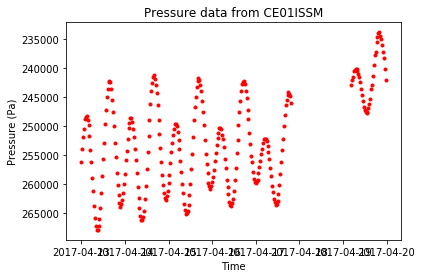

In [0]:
# First, let's make a timeseries of pressure
plt.plot_date(p_time,p_pr,'r.')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Pressure (Pa)')
plt.title('Pressure data from CE01ISSM');

In [0]:
ds['temperature'].units

'cdeg_C'

In [0]:
ds['pressure'].units

'daPa'

As noted in the annotation above, during Deployment 6, the profiler stopped profiling on the 04/17/2018 and restarted deployment for deploymnet 7 on 04/19/2018.  So the gap visible for the 04/18/2018 is clearly visible in the data. The pressure oscillates between highs and lows in both deployment periods but the average pressure for depl. 7 is higher than that for depl. 6.

For another perspective, let's take a look at the temperature and salinity profiles. In both of the 2 graphs below we again clearly see the gap on the 04/19/2018 corresponding to the change in deployment from 6 to 7. The temperature variation is very small (from 10.9-11.2 degrees C) which seems a reasonable change over a short period of time of a few days. The salinity is again constact at 33 for all time periods considered (whether its a week or the entire period of 3 years covering all the deployments).

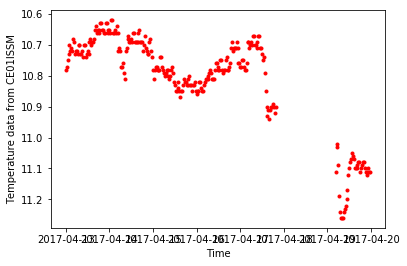

In [0]:
# Now, let's make a timeseries of temperature
plt.plot_date(p_time,p_temp,'r.')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Temperature data from CE01ISSM');

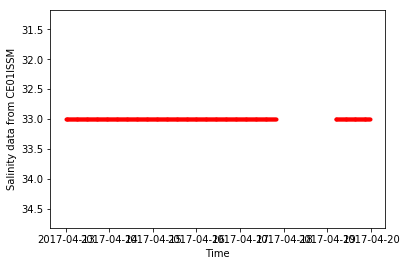

In [0]:
# Now, let's make a timeseries of salinity
plt.plot_date(p_time,p_sal,'r.')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Salinity data from CE01ISSM');

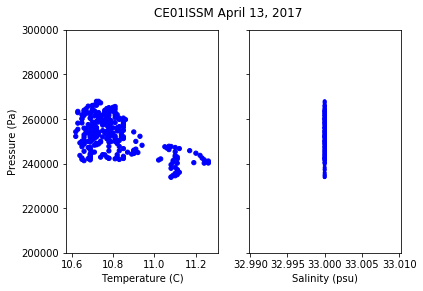

In [0]:
# Profile plots of temperature and salinity
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Create a color map to divide the two deployments
kcolors = ['red' if t<datetime.datetime(2017,4,13) else 'blue' for t in p_time]

ax1.scatter(p_temp,p_pr, c=kcolors, s=18)
# ax1.plot(p_temp,p_pr,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (Pa)')
# ax1.invert_yaxis()
ax1.set_ylim(200000,300000)

ax2.scatter(p_sal,p_pr, c=kcolors, s=8)
# ax2.plot(p_sal,p_pr,'r.',label='Pioneer Profiler')
ax2.set_xlabel('Salinity (psu)')
fig.suptitle('CE01ISSM April 13, 2017')
fig.subplots_adjust(top=0.9);


  Both the temperature and salinity are for single day i.e. the 04/13/2018 and look reasonable. The temperature graph tends to show points regrouping in 2 groups, one around 10.7 degrees and another around 11.1.

## 7. Notable Results and Actions Needed


Based on this analysis of the Coastal Endurance Oregon Inshore Surface Mooring - Seafloor Multi-Function Node (MFN) - Velocity Profiler (600kHz), we note the following takeaways:

* In general, all the parameters studied i.e. the temperature, salinity, pressure, pitch, heading, bin distance and bin depth as well as eastward, northward and upward velocity values during deployment 7 and 3 look largely reasonable.  There are some outliers, such as for pressure and heading in deployment 7.
* The data seems to align with known physical processes, though additional datasets would need to be consulted to confirm. 
* The ADCP was working during Deployment 8 but the data is injust so not available and deplyoment 9 is currentlty taking place so no data is available there either.
* The data for depl. 3 is of a higher quality than for depl. 7, at least as far as the heading is concerned. (For depl. 7 we have outlyer values that give an erroneous impression about the average heading).
* The units of pitch, roll, and heading should be in centi-degree instead of deci-degree. Thus units in which the heading, roll and pitch are recorded is wrong so they have to be divided by 100 in order to have more understandable and acceptable units.

* If we compare the results from the Coastal Endurance Oregon Inshore Surface Mooring here above to the Coastal Pioneer Central inshore profiler carried out by Kianoosh Yousefi, we come to the conclusion that in general both datasets present high quality data without any major outlyers or discrepancies.

